In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio
import cv2
from scipy.spatial.distance import euclidean
from pathlib import Path
from tqdm import trange
from flygym.envs.nmf_mujoco import MuJoCoParameters
from flygym.arena.mujoco_arena import OdorArena
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs
from flygym.util.data import color_cycle_rgb

from flygym.util.turning_controller import TurningController

In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [3]:
odor_source = np.array([[24, 0, 1.5], [8, -4, 1.5], [16, 4, 1.5]])
peak_intensity = np.array([[1, 0], [0, 1], [0, 1]])


def run_trial(
    spawn_pos,
    spawn_orientation,
    odor_source,
    peak_intensity,
    attractive_gain=500,
    aversive_gain=80,
    run_time=5,
    video_path=None,
):
    marker_colors = [color_cycle_rgb[1]] + [color_cycle_rgb[0]] * (len(odor_source) - 1)
    marker_colors = [(*np.array(color) / 255, 1) for color in marker_colors]
    odor_dimesions = len(peak_intensity[0])
    second_cam_frames = []
    odor_history = []
    arena = OdorArena(
        size=(300, 300),
        odor_source=odor_source,
        peak_intensity=peak_intensity,
        diffuse_func=lambda x: x**-2,
        marker_colors=marker_colors,
        marker_size=0.3,
    )

    sim_params = MuJoCoParameters(
        timestep=1e-4,
        render_mode="saved",
        render_playspeed=0.5,
        render_fps=30,
        render_window_size=(700, 560),
        enable_olfaction=True,
        enable_adhesion=True,
        draw_adhesion=False,
        render_camera="birdeye_cam",
    )

    sim = TurningController(
        sim_params=sim_params,
        arena=arena,
        init_pose=stretched_pose,
        actuated_joints=all_leg_dofs,
        spawn_pos=spawn_pos,
        spawn_orient=spawn_orientation,
    )

    obs_hist = []
    attractive_bias_hist = []
    aversive_bias_hist = []
    stearing_hist = []
    # decreasing_count = 0
    decision_interval = 0.05
    num_decision_steps = int(run_time / decision_interval)
    physics_steps_per_decision_step = int(decision_interval / sim_params.timestep)

    obs, _ = sim.reset()
    for i in trange(num_decision_steps):
        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
        )
        attractive_bias = (
            attractive_gain
            * (attractive_intensities[0] - attractive_intensities[1])
            / attractive_intensities.mean()
        )
        aversive_bias = (
            aversive_gain
            * (aversive_intensities[0] - aversive_intensities[1])
            / aversive_intensities.mean()
        )
        effective_bias = aversive_bias - attractive_bias
        # effective_bias_norm = np.tanh(np.abs(effective_bias) ** 1.3) * np.sign(effective_bias)
        effective_bias_norm = np.tanh(effective_bias**2) * np.sign(effective_bias)
        assert np.sign(effective_bias_norm) == np.sign(effective_bias)
        control_signal = np.ones((2,))
        control_signal[int(effective_bias_norm > 0)] -= (
            np.abs(effective_bias_norm) * 0.8
        )
        # print(intensities)
        # print(attractive_bias, aversive_bias, effective_bias)
        # print(control_signal)
        for j in range(physics_steps_per_decision_step):
            obs, _, _, _, _ = sim.step(control_signal)
            rendered_img = sim.render()
            if rendered_img is not None:
                # render a second image
                second_img = sim.physics.render(
                    width=700, height=560, camera_id="birdeye_cam_zoom"
                )
                second_img = cv2.putText(
                    np.ascontiguousarray(second_img),
                    f"{sim_params.render_playspeed}x",
                    org=(20, 30),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.8,
                    color=(0, 0, 0),
                    lineType=cv2.LINE_AA,
                    thickness=1,
                )
                second_cam_frames.append(second_img)
                # record odor intensity too for video
                odor_history.append(obs["odor_intensity"])
        obs_hist.append(obs)
        attractive_bias_hist.append(attractive_bias)
        aversive_bias_hist.append(aversive_bias)
        stearing_hist.append(effective_bias_norm)

        if np.linalg.norm(obs["fly"][0, :2] - odor_source[0, :2]) < 2:
            break

    if video_path is not None:
        sim.save_video(video_path)

    return (
        sim,
        obs_hist,
        attractive_bias_hist,
        aversive_bias_hist,
        stearing_hist,
        second_cam_frames,
        odor_history,
    )

In [4]:
(
    sim,
    obs_hist,
    attractive_bias_hist,
    aversive_bias_hist,
    stearing_hist,
    second_cam_frames,
    odor_hist,
) = run_trial(
    # spawn_pos=(-0.35355949,  2.91725038, 0.2),
    # spawn_orientation=[0, 0, 1, 0.75181193],
    spawn_pos=(0, 0, 0.2),
    spawn_orientation=[0, 0, np.pi / 2],
    run_time=5,
    odor_source=odor_source,
    peak_intensity=peak_intensity,
    video_path=f"outputs/odor_taxis.mp4",
)

 74%|███████▍  | 74/100 [01:46<00:37,  1.44s/it]


In [5]:
def add_insets(
    viz_frame, odor_intensities, odor_colors, odor_gain=400, panel_height=150
):
    final_frame = np.zeros(
        (viz_frame.shape[0] + panel_height + 5, viz_frame.shape[1], 3), dtype=np.uint8
    )
    final_frame[: viz_frame.shape[0], :, :] = viz_frame

    assert np.array(odor_intensities).shape == (2, 4)
    odor_intensities = np.array(odor_intensities).reshape(2, 2, 2).mean(axis=1)
    unit_size = panel_height // 5

    for i_odor in range(2):
        for i_side in range(2):
            row_start = unit_size + i_odor * unit_size * 2 + viz_frame.shape[0] + 5
            row_end = row_start + unit_size
            width = int(odor_intensities[i_odor, i_side] * odor_gain)
            if i_side == 0:
                col_start = 0
                col_end = width
            else:
                col_start = final_frame.shape[1] - width
                col_end = final_frame.shape[1]
            final_frame[row_start:row_end, col_start:col_end, :] = odor_colors[i_odor]

    return final_frame

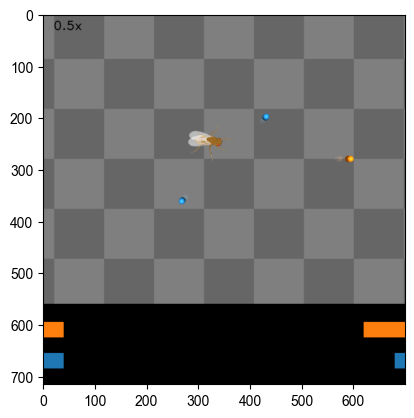

In [6]:
inset = add_insets(
    sim._frames[100],
    [[0.1, 0.2, 0.1, 0.2], [0.1, 0.05, 0.1, 0.05]],
    [color_cycle_rgb[1], color_cycle_rgb[0]],
)
plt.imshow(inset)

In [7]:
stabilization_time = 0.05
num_stab_frames = int(np.ceil(stabilization_time / sim._eff_render_interval))

path = Path("outputs/odor_taxis.mp4")
path.parent.mkdir(parents=True, exist_ok=True)
with imageio.get_writer(path, fps=sim.sim_params.render_fps) as writer:
    for frame, odor_intensities in zip(second_cam_frames, odor_hist):
        frame = add_insets(
            frame,
            odor_intensities,
            odor_gain=600,
            odor_colors=[color_cycle_rgb[1], color_cycle_rgb[0]],
        )
        writer.append_data(frame)

In [8]:
sample_interval = 30
individual_frames_dir = Path("outputs/individual_frames")
individual_frames_dir.mkdir(parents=True, exist_ok=True)

offset = len(sim._frames) % sample_interval - 1
# print(len(sim._frames), offset)
selected_images = np.array(
    [sim._frames[i] for i in range(offset, len(sim._frames), sample_interval)]
)
background = np.median(selected_images, axis=0)

for i in trange(0, selected_images.shape[0]):
    img = selected_images[i, :, :, :]
    is_background = np.isclose(img, background, atol=1).all(axis=2)
    img_alpha = np.ones((img.shape[0], img.shape[1], 4)) * 255
    img_alpha[:, :, :3] = img
    img_alpha[is_background, 3] = 0
    img_alpha = img_alpha.astype(np.uint8)
    # break
    imageio.imwrite(
        individual_frames_dir / f"frame_{i}.png", img_alpha
    )

imageio.imwrite(individual_frames_dir / "background.png", background.astype(np.uint8))

100%|██████████| 8/8 [00:00<00:00, 20.96it/s]
